# Pre-operative Imaging Concordance Analysis


### Key Terms


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
preop_imaging_df = pd.read_excel('Data/raw_imaging_data.xlsx')

In [2]:
# Clean column names by removing whitespace
preop_imaging_df.columns = preop_imaging_df.columns.str.strip()

## Concordance Analysis

Calculates how well each imaging modality's findings match surgical findings, categorized as Exact, Side, or Incorrect Localization.

In [3]:
# Calculate Concordance for Each Modality
modalities = ['SPECT/CT', '4D CT Scan', 'Ultrasound', 'Sestamibi', 'MRI']

In [4]:
"""
    Determines concordance between imaging modality findings and surgical findings.

    Parameters:
        row (pd.Series): A row from the dataframe containing imaging and surgical data.
        modality_col (str): The column name of the imaging modality to evaluate.

    Returns:
        str: Concordance category, one of:
            - 'Yes (Exact)'
            - 'Yes (Side)'
            - 'Incorrect Localization'
            - 'Non-localizing'
            - 'No Scan'
            - 'Unknown'
"""

def check_concordance(row, modality_col):
    
    imaging = row[modality_col]
    surgical = row['Surgical Findings']

    # Return Unknown if imaging or surgical data is missing
    if pd.isnull(imaging) or pd.isnull(surgical):
        return 'Unknown'

    # Handle No Scan and Non-localizing 
    if imaging == 'No Scan':
        return 'No Scan'
    if imaging == 'Non-localizing':
        return 'Non-localizing'

    # If surgery found 4 gland hyperplasia, any single imaging finding is incorrect
    if 'hyperplasia' in surgical.lower():
        return 'Incorrect Localization'

    # Split and clean imaging and surgical gland strings into sets
    imaging_glands = [g.strip().lower() for g in imaging.split(',')]
    surgical_glands = [g.strip().lower() for g in surgical.split(',')]
    imaging_set = set(imaging_glands)
    surgical_set = set(surgical_glands)

    # Exact match is when all surgical glands found in imaging
    if surgical_set.issubset(imaging_set):
        return 'Yes (Exact)'

    # extracts the imaging side
    imaging_sides = set()
    for ig in imaging_glands:
        if 'left' in ig:
            imaging_sides.add('left')
        if 'right' in ig:
            imaging_sides.add('right')

    # Only return 'Yes (Side)' if all surgical gland sides are found
    for sg in surgical_glands:
        if 'left' in sg and 'left' not in imaging_sides:
            return 'Incorrect Localization'
        if 'right' in sg and 'right' not in imaging_sides:
            return 'Incorrect Localization'

    return 'Yes (Side)'

In [5]:
# Loop through modalities and collect counts + percentages

summary_data = []

for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'

    # Calculate concordance for each row and store in a new column
    preop_imaging_df[concordance_col] = preop_imaging_df.apply(
        lambda row: check_concordance(row, modality), axis=1
    )
    
    # Filter to localizing rows only
    localizing_df = preop_imaging_df[
        ~preop_imaging_df[concordance_col].isin(['Unknown', 'Non-localizing'])
    ].copy()
    
    # Calculate value counts and total count
    counts = localizing_df[concordance_col].value_counts()
    total = counts.sum()
    
    for match_type, count in counts.items():
        pct = round((count / total) * 100 if total > 0 else 0, 2)
        
        # Append results as dictionaries to summary_data list
        summary_data.append({
            'Modality': modality,
            'Concordance': match_type,
            'Count': count,
            'Percentage': pct
        })

In [6]:
# Convert to DataFrame
concordance_summary_df = pd.DataFrame(summary_data)

# Pivot for grouped bar plot preparation (optional)
pivot_df = concordance_summary_df.pivot(index='Modality', columns='Concordance', values='Percentage').fillna(0)

# Reorder columns 
ordered_cols = ['Yes (Exact)', 'Yes (Side)', 'Incorrect Localization']
pivot_df = pivot_df.reindex(columns=ordered_cols).fillna(0)

# Display results
display(concordance_summary_df)
display(pivot_df)

,Modality,Concordance,Count,Percentage
0,SPECT/CT,Yes (Side),82,46.07
1,SPECT/CT,Yes (Exact),72,40.45
2,SPECT/CT,Incorrect Localization,24,13.48
3,4D CT Scan,Yes (Exact),78,45.09
4,4D CT Scan,Yes (Side),58,33.53
5,4D CT Scan,Incorrect Localization,37,21.39
6,Ultrasound,Yes (Side),43,55.13
7,Ultrasound,Yes (Exact),26,33.33
8,Ultrasound,Incorrect Localization,9,11.54
9,Sestamibi,Yes (Side),62,54.87


Concordance,Yes (Exact),Yes (Side),Incorrect Localization
Modality,,,
4D CT Scan,45.09,33.53,21.39
MRI,50.00,25.00,25.00
SPECT/CT,40.45,46.07,13.48
Sestamibi,40.71,54.87,4.42
Ultrasound,33.33,55.13,11.54


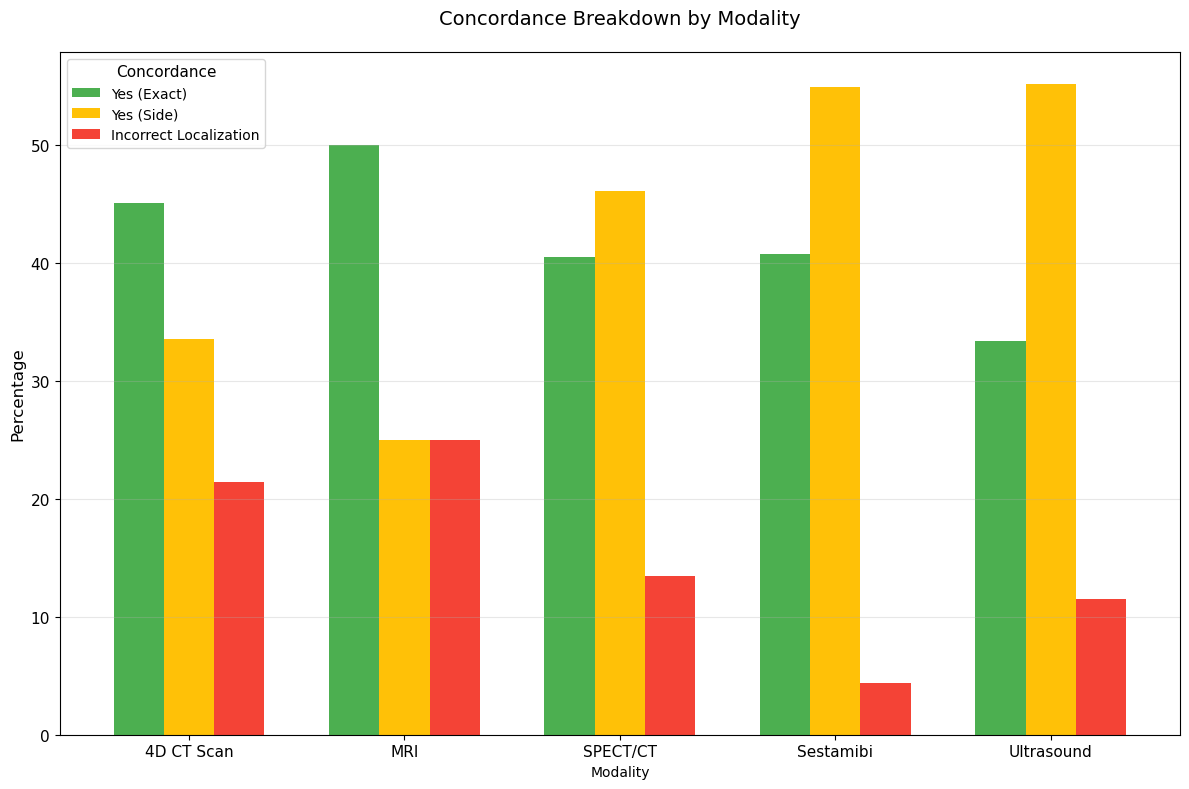

In [7]:
# Plot grouped bar plot
pivot_df.plot(
    kind='bar',
    figsize=(12,8),
    color=['#4CAF50', '#FFC107', '#F44336'],  
    width=0.7
)

plt.ylabel('Percentage', fontsize=12)
plt.title('Concordance Breakdown by Modality', fontsize=14, pad=20)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Concordance', fontsize=10, title_fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
preop_imaging_df.columns

Index(['Date of Procedure', 'Patient ID', 'Age', 'Gender', 'Surgical Findings',
       'Surgical Cure', 'SPECT/CT', 'Ultrasound', '4D CT Scan', 'Sestamibi',
       'MRI', 'SPECT/CT Calculated Concordance',
       '4D CT Scan Calculated Concordance',
       'Ultrasound Calculated Concordance', 'Sestamibi Calculated Concordance',
       'MRI Calculated Concordance'],
      dtype='object')

In [9]:
# create a function to extract the side 
def extract_surgical_side(surgical):
    # check if the surgical side is null
    if pd.isnull(surgical):
        return 'Unknown'
    
    surgical = surgical.lower()
    has_left = 'left' in surgical
    has_right = 'right' in surgical

    if has_left and has_right:
        return 'Left & Right'
    elif has_left:
        return 'Left'
    elif has_right:
        return 'Right'
    else:
        return 'Unknown'

# Apply to dataframe

# create a column called surgical side that displays the side found in sugery 
preop_imaging_df['Surgical Side'] = preop_imaging_df['Surgical Findings'].apply(extract_surgical_side)
# preop_imaging_df.to_excel('Data/2_clean_imaging_data.xlsx', index=False)

## Success Evaluation

Patients were labeled "Success" if they were cured and had at least one concordant imaging modality (Exact or Side match).


In [14]:
# create the function that checks if each procedure was a success
def check_success(row, modalities):
    # check if the patient was cured 
    if str(row['Surgical Cure']).strip().lower() != 'yes':
        return 'No'
    
    # check if modality was concordant, similar as before
    for modality in modalities:
        concordance_col = modality + ' Calculated Concordance'
        if concordance_col in row:
            result = row[concordance_col]
            if result in ['Yes (Exact)', 'Yes (Side)']:
                return 'Yes'
            
    return 'No'

# apply the function to df 
preop_imaging_df['Success'] = preop_imaging_df.apply(lambda row: check_success(row, modalities), axis=1)

In [20]:
# calculate the success rate for each modality 

# initialize a summary list 
modality_success_summary = []

for modality in modalities:
    col = modality + ' Calculated Concordance'

    # filter for patients with concordant imaging 
    concordant = preop_imaging_df[preop_imaging_df[col].isin(['Yes (Exact)', 'Yes (Side)'])]

    # Count how many were cured
    cured_count = concordant[concordant['Surgical Cure'].str.strip().str.lower() == 'yes'].shape[0]
    total_concordant = concordant.shape[0]

    # get the sucess rate 
    success_rate = round((cured_count / total_concordant) * 100, 2) if total_concordant > 0 else 0

    modality_success_summary.append({
        'Modality': modality,
        'Concordant Patients': total_concordant,
        'Cured Patients': cured_count,
        'Success Rate (%)': success_rate
    })

# Convert to dataframe
modality_success_df = pd.DataFrame(modality_success_summary)
display(modality_success_df)

,Modality,Concordant Patients,Cured Patients,Success Rate (%)
0,SPECT/CT,154,153,99.35
1,4D CT Scan,136,133,97.79
2,Ultrasound,69,67,97.10
3,Sestamibi,108,107,99.07
4,MRI,6,6,100.00


Make sure the logic for calculating success rate works properly

In [23]:
# test the logic with 2 modalites

# show all rows where Sestamibi was concordant 
sestamibi_concordant = preop_imaging_df[preop_imaging_df['Sestamibi Calculated Concordance'].isin(['Yes (Exact)', 'Yes (Side)'])]

# of those, how many were cured?
sestamibi_concordant['Surgical Cure'].value_counts()


spect_concordant = preop_imaging_df[preop_imaging_df['SPECT/CT Calculated Concordance'].isin(['Yes (Exact)', 'Yes (Side)'])]
spect_concordant['Surgical Cure'].value_counts()

Surgical Cure
Yes    153
No       1
Name: count, dtype: int64